# Stroke Prediction Classification


### **Introduction:**

The 5th highest cause of death and the leading cause of disability in the United States is due in part to strokes (Cerebrovascular Accidents). Strokes are the result of an insufficient supply of oxygen and nutrients to the brain due to a blood vessel bursting. Subsequently, brain cells die, which can often cause right-sided weakness/paralysis, and sensory impairment.

**Research Question**:
Based on multiple numerical clinical features, is someone likely to experience a stroke (or have they already experienced one)?

This 12-column dataset pertaining to Medical Stroke Data was acquired from kaggle.com. It contains factors that may affect someone’s likelihood of experiencing a stroke, a record of whether or not the patient experienced a stroke, and identifying information.

In [25]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(ggplot2)
# library(themis)
options(repr.matrix.max.rows = 6)


set.seed(1234)

### **Preliminary Exploratory Data Analysis:**

Although not all values are used, we must ensure that we properly tidy the data into a usable format. Tidy data entails:
* Each row has a single observation.
* Each column has a single variable.
* Each value is in a single cell.

The data includes all these components except for the fact that there are N/A values in the bmi column of the dataset. However, the missing values must be counted later on once the data is split into the training set. Consequently, the missing vales will remain in the dataset until after the missing values are counted.

Changing each variable to its correct type can be beneficial (even if it is not used), since it will help with usability later on if needed. This can be done before the data is split into the training and testing set. Patient ID can be de-selected since identifying information is not relevant to the project.

In [2]:
url <- "https://raw.githubusercontent.com/romansinkus/DS_Group_Project/main/healthcare-dataset-stroke-data.csv"
untidy_stroke_data <- read_csv(url)
stroke_data <- untidy_stroke_data %>%
    select(-id) %>% 
    mutate(bmi = as.numeric(bmi)) %>% 
    rename(residence_type = Residence_type) %>% 
    mutate(across(c(gender, hypertension:residence_type, smoking_status:stroke), as_factor))

stroke_data

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Now that the data has been optimized for usability (but not completely tidied), it can be split into testing and training data (75% will be allocated as training data).

In [3]:
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke)
initial_stroke_train <- training(stroke_split)
initial_stroke_test <- testing(stroke_split)

Below is a table summarizing the three different numerical variables that are possible predictors for the model. The mean values have been calculated for each.

In [4]:
avg_values <- initial_stroke_train %>% 
    summarize(age_avg = mean(age, na.rm = TRUE),
            avg_glucose_level_avg = mean(avg_glucose_level, na.rm = TRUE),
            bmi_avg = mean(bmi, na.rm = TRUE))
avg_values

age_avg,avg_glucose_level_avg,bmi_avg
<dbl>,<dbl>,<dbl>
43.0887,106.3249,28.86223


Based on the summarization of the training data, most patients indicated they were middle-aged and had healthy average glucose levels (healthy range: 90-110 mg/dL). The average patient observed exhibited a body mass index indicating they were in the "overweight" category (25.0—29.9).

Kaggle (the website where the dataset was collected) indicated missing values for the bmi column of the dataset. Shown below is the number of rows that include missing values.

In [5]:
missing_bmi <- initial_stroke_train %>%
    select(bmi) %>%
    count(is.na(bmi))
missing_bmi

is.na(bmi),n
<lgl>,<int>
FALSE,3670
TRUE,163


The stroke variable is the target variable for this model. Below is a table containing the number of patients who indicated they had experienced a stroke (1 = yes, 0 = no).

In [6]:
categorical_values <- initial_stroke_train %>%
    group_by(stroke) %>% 
    summarize(n = n())

categorical_values

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,3652
1,181


Now that the missing values have been counted and displayed, they can be removed to make the data tidy (each value must be in a single cell).

In [7]:
stroke_train <- initial_stroke_train %>% 
    filter(!is.na(bmi))

stroke_test <- initial_stroke_test %>% 
    filter(!is.na(bmi))

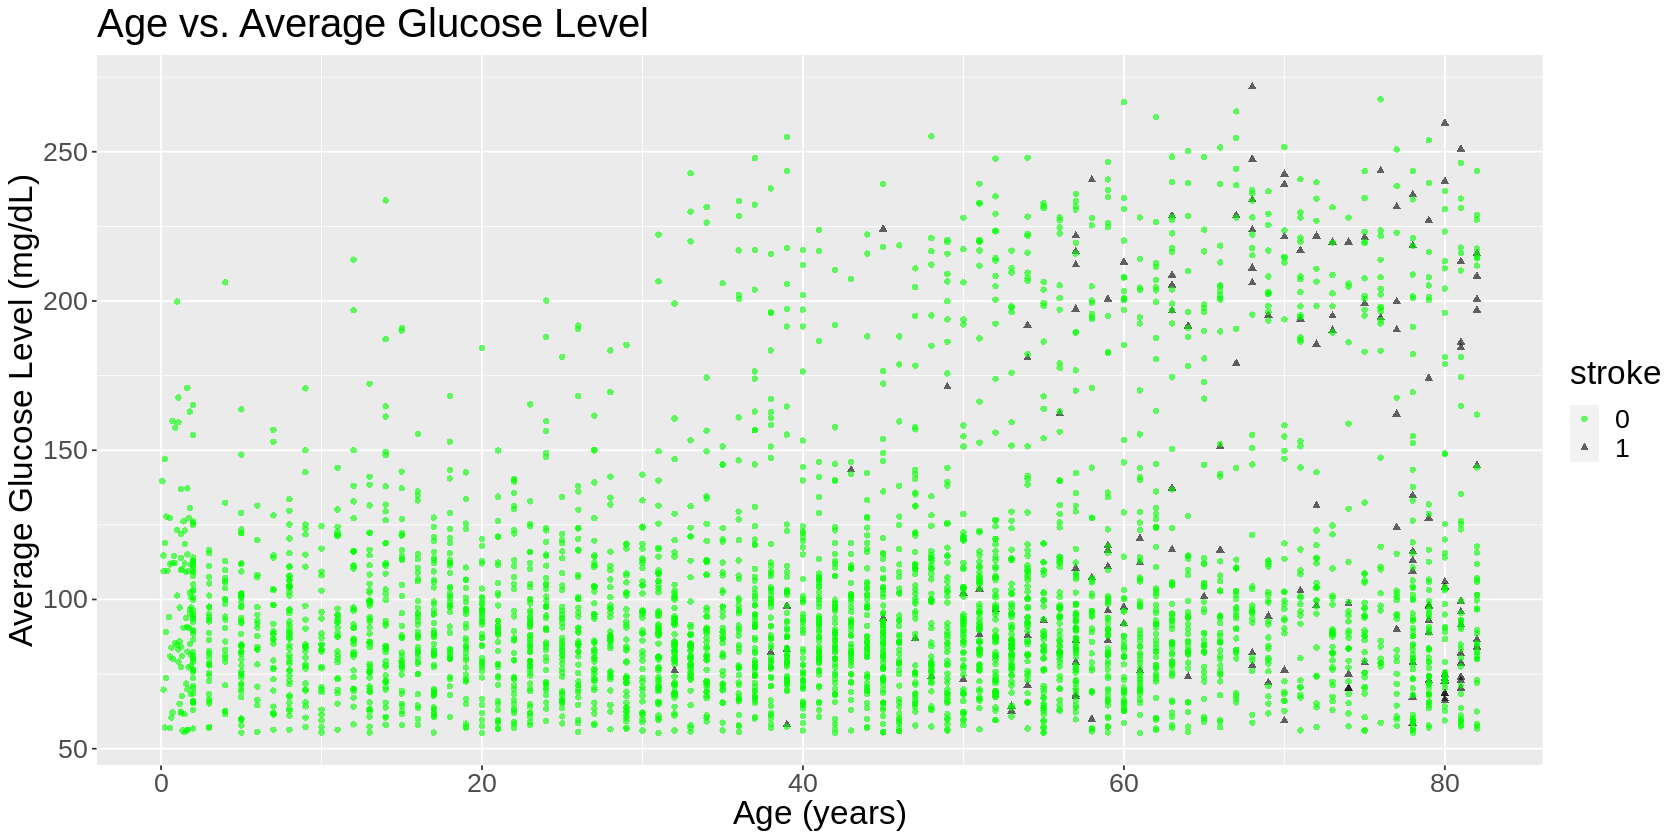

In [8]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = avg_glucose_level))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(x = "Age (years)", y = "Average Glucose Level (mg/dL)", fill = "Stroke")+
    ggtitle("Age vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    #scale_fill_brewer(palette = "Set2")
    scale_colour_manual(values = c("green", "black"))

age_vs_avg_glucose_level_plot

This plot shows two possible predictors that can be used to classify the target variable (stroke). The higher the age of a patient, the greater amount of patients appear to have had strokes. However, there does not seem to be a greater number patients with strokes as the average glucose level increases or decreases.

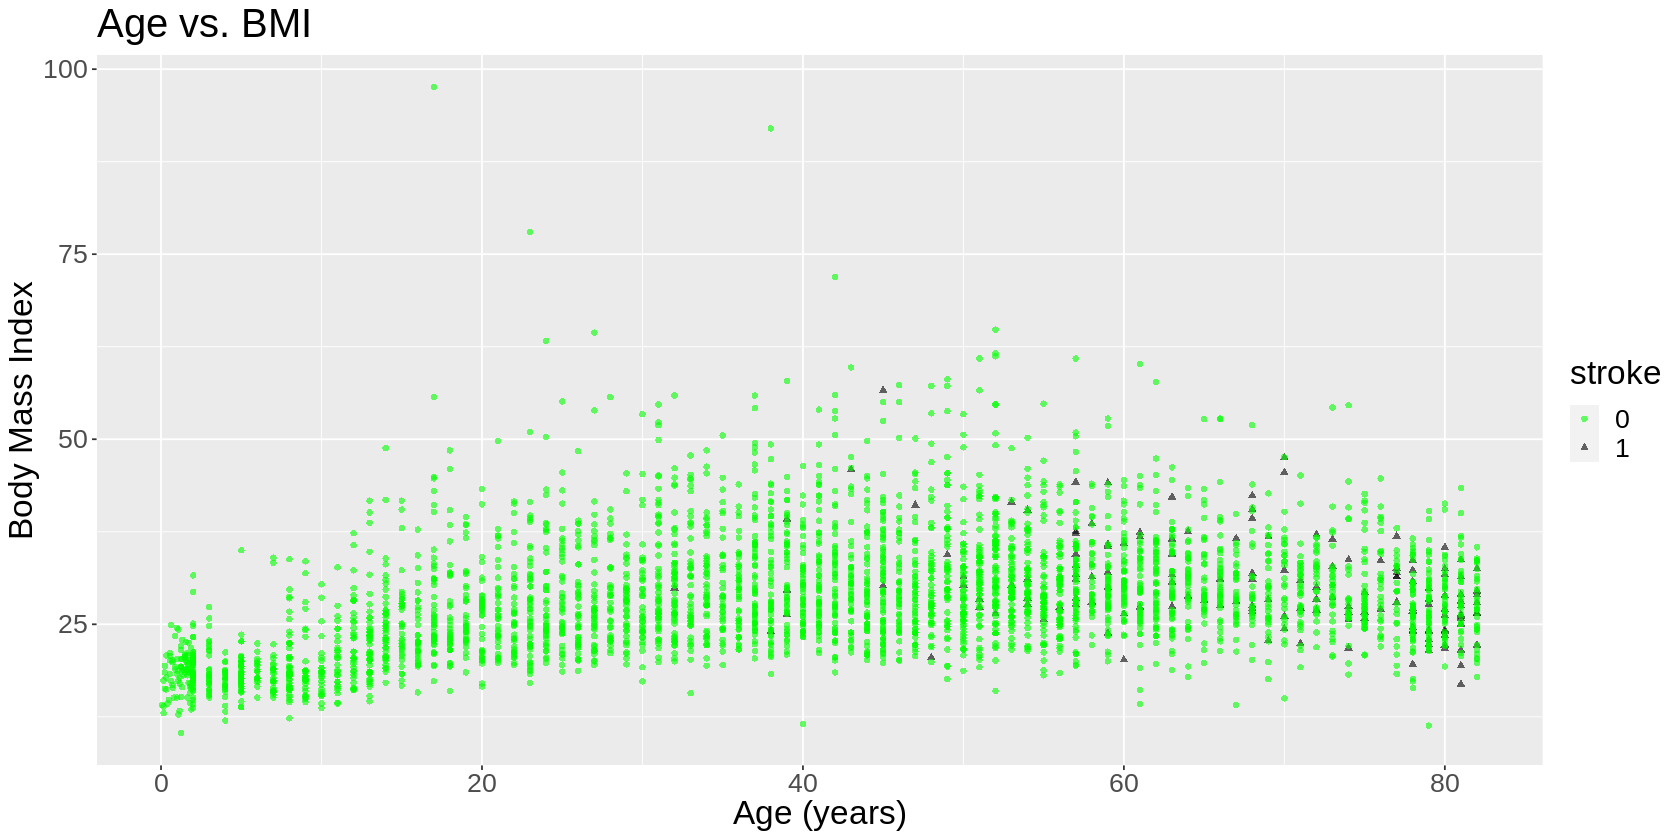

In [9]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_bmi_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = bmi))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(x = "Age (years)", y = "Body Mass Index", fill = "Stroke")+
    ggtitle("Age vs. BMI")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

age_vs_bmi_plot

This plot shows a greater density of stroke points in the upper, right hand corner. This means that patients with a higher BMI and older age were more prone to suffering from strokes.

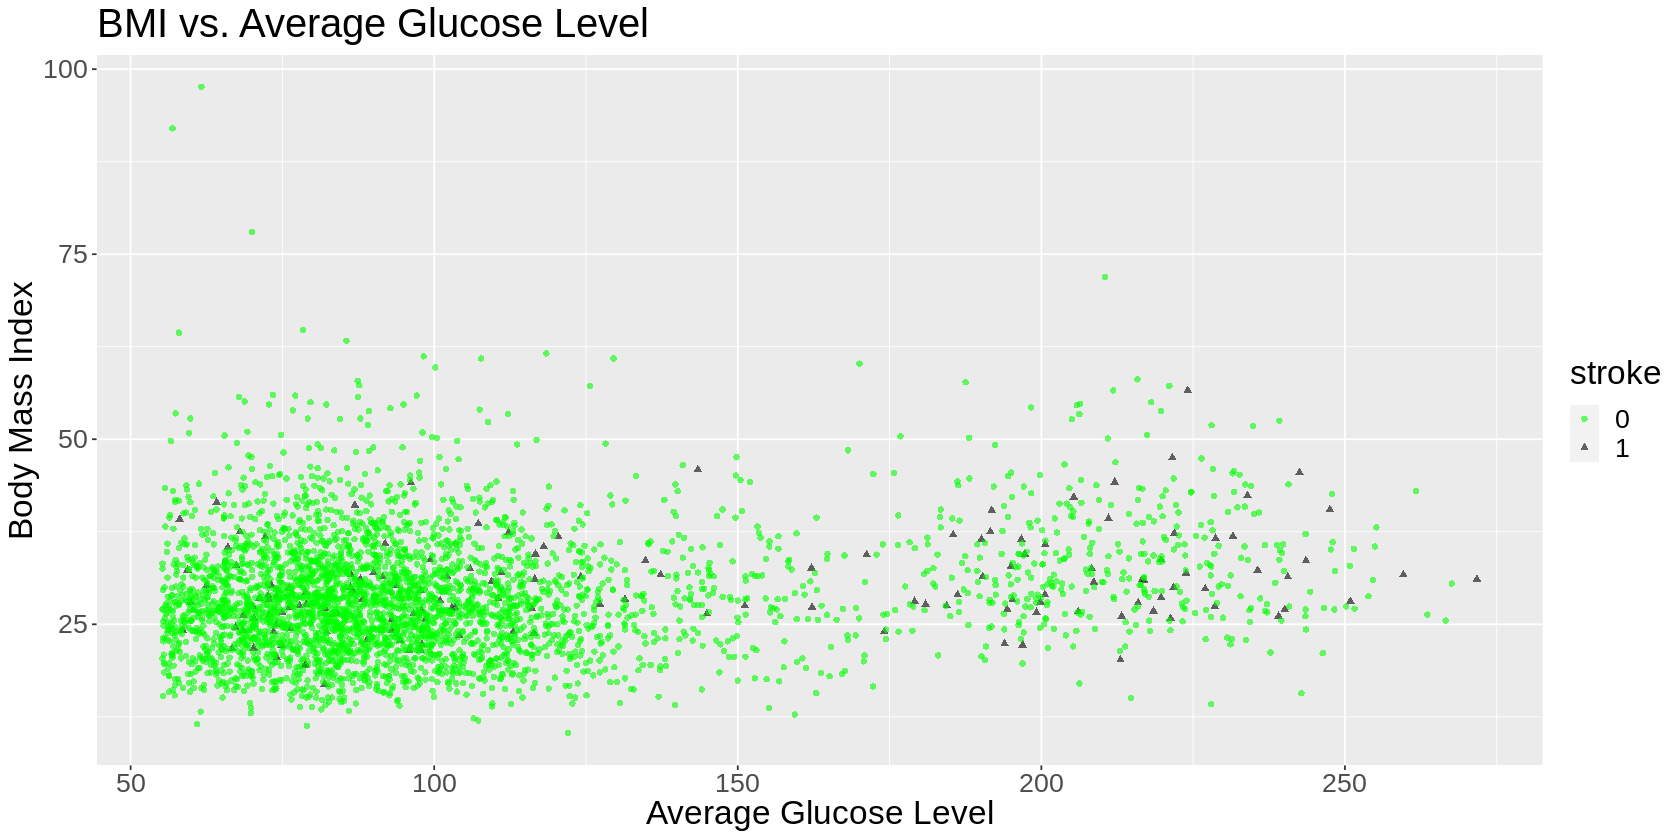

In [10]:
bmi_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(y = bmi, x = avg_glucose_level))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.6)+
    labs(y = "Body Mass Index", x = "Average Glucose Level", fill = "Stroke")+
    ggtitle("BMI vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

bmi_vs_avg_glucose_level_plot

This plot shows a somewhat even distribution of the stroke points from left to right, however, there is much greater density of non-stroke points on the left side (lower average glucose level). This means that people with higher average glucose levels are more likely to experience strokes based on the graph. This relationship was unclear in the last graph containing average glucose level, likely due to it being graphed on the y-axis. The stroke points also correlate to a higher BMI.

### **Methods:**

For our data analysis, we created 3 plots to see the relationship between BMI, age and average glucose level of the patient to see which factors contributed to strokes. 3 numerical variables in the dataset were considered because numerical variables best contribute to the kknn classification model. After observing all plots, we concluded that we would use all three variables examined because each showed a correlation to strokes (higher BMI, higher average glucose level, and older age).

After creating a summary table analyzing the number of people that suffered from a stroke, we found a class imbalance as the 190 experienced a stroke whereas 3643 did not, which can lead to bias with the classifier. To solve this problem, when creating the classification model, we will rebalance the data by oversampling the stroke = 1 case to give it more voting power, resulting in a more accurate prediction.

To predict the testing set, we will use cross-validation to split our training data. Then, we will create a recipe that specifies the class label and our 3 predictors and create nearest_neighbor model specification to choose the k with the highest accuracy. Consequently, we add the model and recipe to a workflow and pick a suitable k value. We will then use this value to come up with a prediction subsequently calculate the accuracy of our model.

We will visualize the results by plotting the different predictors (using multiple different graphs), and whether or not the predictions were accurate.

### **Expected Outcomes and Significance:**

We expect to find a trend that can help determine if a patient is more likely to suffer from a stroke. For example, being overweight or having a higher bmi, would mean the patient is more likely to suffer from a stroke. Also, patients of older age would be of higher risk of having a stroke. 

Using this prediction, predicting a stroke would be an easier and more efficient process. It could help many patients seek help at an early stage. Using this classification model, doctors and patients can easily input different diagnostics and obtain a prediction of whether they are at-risk for having a stroke, based on data from past patients. This could be used as a preliminary step in the process to diagnosing patients (or patients seeking diagnosis).

This could lead to other questions such as what other numerical clinical features contribute to strokes, and can they improve the accuracy of the model? Additionally, this same method can be used to detemine predictions for other illnesses.

### **KNN Classification**

In [11]:
stroke_data_scaled <- stroke_data %>% 
    mutate(scaled_age = scale(age, center = TRUE),
            scaled_bmi = scale(bmi, center = TRUE),
            scaled_avg_glucose_level = scale(avg_glucose_level, center = TRUE))

In [36]:
stroke_recipe <- recipe(stroke ~ bmi + avg_glucose_level + age, data = stroke_train) %>%
    step_upsample(stroke, over_ratio = 1, skip = TRUE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

stroke_recipe

#upsampled_stroke %>% 
#    group_by(stroke) %>% 
#    summarize(n = n())

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Up-sampling based on stroke
Scaling for all_predictors()
Centering for all_predictors()

In [37]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [38]:
#stroke_recipe <- recipe(stroke ~ bmi + age + avg_glucose_level, data = upsampled_stroke) %>% 
#    step_scale(all_predictors()) %>% 
#    step_center(all_predictors())

In [39]:
stroke_vfold <- vfold_cv(stroke_train, v = 5, strata = stroke)

In [40]:
# gridvals <- tibble(neighbors = seq(from = 1, to = 3))
# gridvals

In [41]:
# gridvals <- tibble(neighbors = c(seq(from = 1, to = 5), seq(from = 5, to = 50, by = 5)))

gridvals <- tibble(neighbors = seq(from = 1, to = 30, by = 5))

stroke_results <- workflow() %>% 
    add_recipe(stroke_recipe) %>%
    add_model(knn_spec) %>% 
    tune_grid(resamples = stroke_vfold, grid = gridvals) %>% 
    collect_metrics()
stroke_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9234332,5,0.002805349,Model1
1,roc_auc,binary,0.5251034,5,0.011866754,Model1
6,accuracy,binary,0.8689373,5,0.006366933,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21,roc_auc,binary,0.7220819,5,0.02187864,Model5
26,accuracy,binary,0.7106267,5,0.00950364,Model6
26,roc_auc,binary,0.7324945,5,0.02482577,Model6


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9234332,5,0.002805349,Model1
6,accuracy,binary,0.8689373,5,0.006366933,Model2
11,accuracy,binary,0.8059946,5,0.006427862,Model3
16,accuracy,binary,0.7738420,5,0.006505360,Model4
21,accuracy,binary,0.7307902,5,0.007407236,Model5
26,accuracy,binary,0.7106267,5,0.009503640,Model6


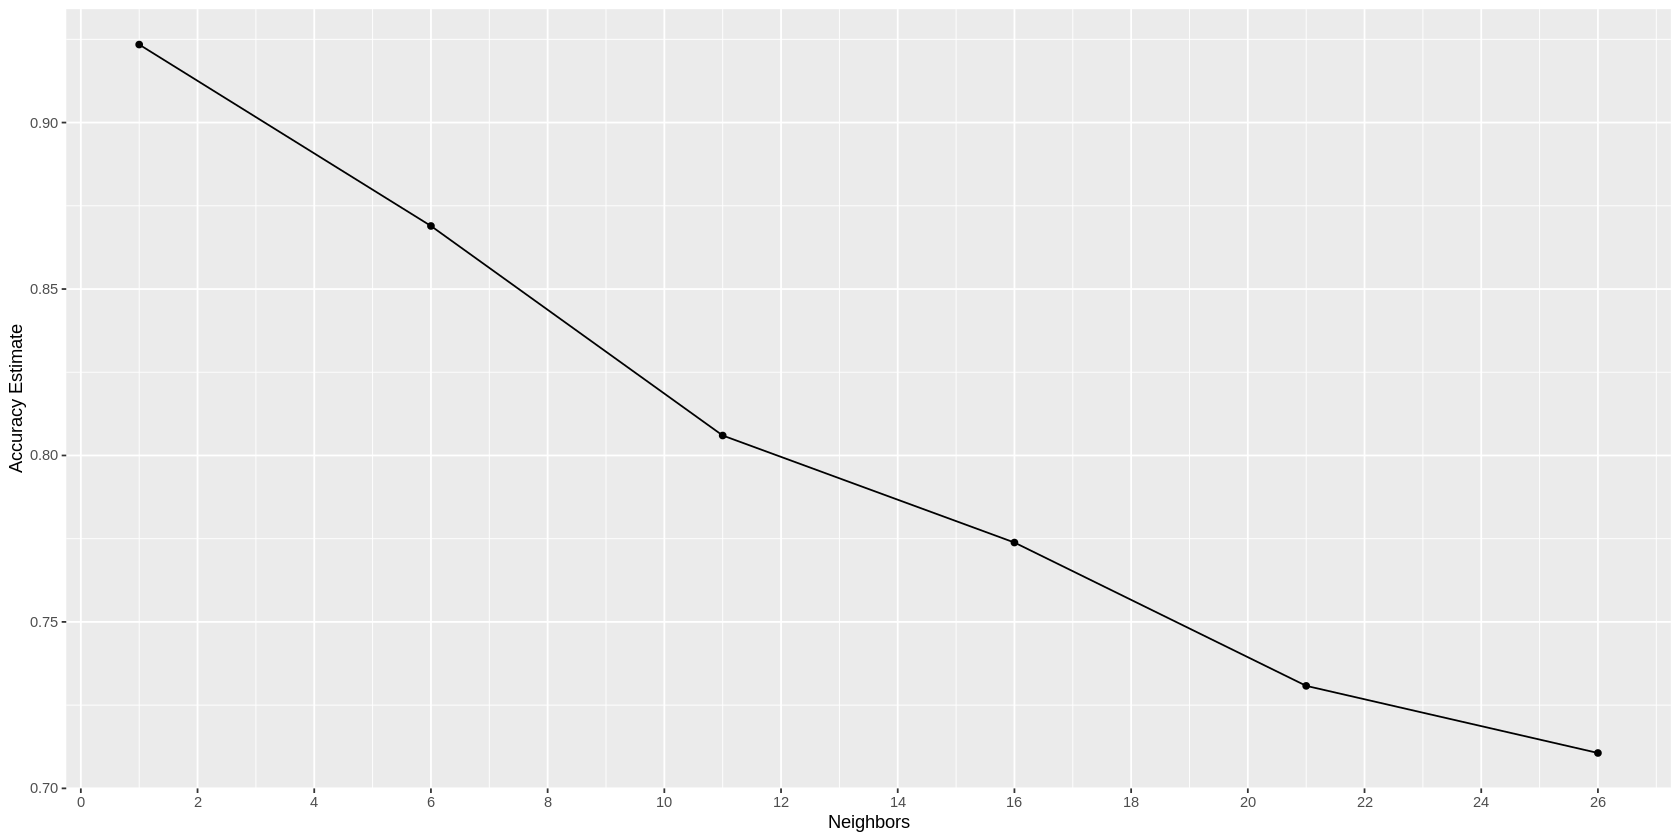

In [42]:
accuracies <- stroke_results %>% 
    filter(.metric == "accuracy")

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
     scale_x_continuous(breaks = seq(0, 30, 2)) 
 #   scale_y_continuous(limits = c(0.7, 1))
# add title 
cross_val_plot

In [19]:
stroke_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.8784741,5,0.005834499,Model01
3,roc_auc,binary,0.5749423,5,0.021747149,Model01
8,accuracy,binary,0.8395095,5,0.005405132,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,roc_auc,binary,0.8001138,5,0.007604805,Model14
73,accuracy,binary,0.8076294,5,0.010235226,Model15
73,roc_auc,binary,0.8067889,5,0.008643766,Model15


In [43]:
k <- 1
k_2 <- 43

In [44]:
stroke_spec_2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = k) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

stroke_fit_2 <- workflow() %>%
    add_recipe(stroke_recipe) %>% 
    add_model(stroke_spec_2) %>% 
    fit(data = stroke_train)

In [45]:
initial_stroke_test
stroke_fit_2

gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Female,81,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
Female,54,0,0,Yes,Private,Urban,104.51,27.3,smokes,1
Female,79,0,1,Yes,Private,Urban,214.09,28.2,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Female,57,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
Female,18,0,0,No,Private,Urban,82.85,46.9,Unknown,0
Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

● step_upsample()
● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02073864
Best kernel: rectangular
Best k: 1

In [46]:
stroke_predictions <- predict(stroke_fit_2, stroke_test) %>% 
    bind_cols(stroke_test)

head(stroke_predictions)
stroke_metrics <- stroke_predictions %>% 
    metrics(truth = stroke, estimate = .pred_class)
stroke_metrics
stokre_conf_mat <- stroke_predictions %>% 
    conf_mat(truth = stroke, estimate = .pred_class)

stokre_conf_mat

.pred_class,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
0,Female,81,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
0,Female,54,0,0,Yes,Private,Urban,104.51,27.3,smokes,1
1,Female,79,0,1,Yes,Private,Urban,214.09,28.2,never smoked,1
0,Female,50,1,0,Yes,Self-employed,Rural,167.41,30.9,never smoked,1
0,Female,60,0,0,No,Private,Urban,89.22,37.8,never smoked,1
0,Female,52,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.91686844
kap,binary,0.07603588


          Truth
Prediction    0    1
         0 1129   52
         1   51    7

### **Discussion**

### **References**

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9264165